<a href="https://colab.research.google.com/github/fedjkeee/Homework/blob/main/Final_project/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 1. Введение

В данном проекте попробуем построить тоновый классификатор сообщений, обученный на размеченных рускоязычных сообщениях в Twitter. Для анализа и обучения будет использоваться корпус из 114,911 положительных и 111,923 отрицательных записей. (Ресурс https://study.mokoron.com/ )

В данных 12 столбцов со следующей информацией (в оригинальном описании были описаны 11 столбцов из 12, пропущенный- кол-во ретвитов записи, был найден по одному из скриншотов):
1. id: уникальный номер сообщения в системе twitter; 
2. tdate: дата публикации сообщения (твита); 
3. tmane: имя пользователя, опубликовавшего сообщение; 
4. ttext:  текст сообщения (твита);
5. ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
6. trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
7. trtw: количество ретвитов записи;
7. tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
8. tstcount: число всех сообщений пользователя в сети twitter;
9. tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);
10. tfrien: количество друзей пользователя (те люди, которых читает пользователь);
11. listcount: количество листов, в которых состоит пользователь.

#### 2. Подготова данных

##### 2.1 Импорт библиотек

В данном разделе, как и в последующих, все необходимые библиотеки будут импортироваться по группам, которые используются в каждом из разделом.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import  Counter
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer 
import re
nltk.download('punkt')
from spacy.lang.ru import Russian
from tqdm import tqdm
tqdm.pandas()  # включим использование tqdm для pandas

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
pip install pymorphy2==0.8

     |████████████████████████████████| 51kB 3.0MB/s 
     |████████████████████████████████| 7.1MB 5.5MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### 2.2 Загрузка данных

In [4]:
neg = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/negative.csv', encoding='utf8', sep=';', header=None)
pos = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/positive.csv', encoding='utf8', sep=';', header=None)

Объеденим данные в один датасет, и сразу перемешаем.

In [5]:
df = pos.append(neg, ignore_index = True)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

226834

Целевой класс обозначен как {-1;1}, заменим на {0,1}

In [6]:
df[4] = df[4].map({-1:0, 1:1})

Добавим имена колонкам с данными

In [7]:
columns=['id','tdate','tmane','ttext','ttype','trep','trtw','tfav','tstcount','tfol','tfrien','listcount']
df.columns=columns

In [8]:
df.head()

,id,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,410837971173408768,1386786379,Divanka394,"@Kathie_Ginger ну, у меня ассоциации, например...",1,0,0,0,6074,117,48,2
1,410402420259561473,1386682536,KolomietsRuslan,"Позвонила в 4 утра,разбудила и начала петь пес...",1,0,0,0,13318,1670,46,0
2,409497410604646400,1386466765,zelenskij,"Теперь вспоминай все слова На ""ум"" в этом горо...",1,0,0,0,578,6,2,0
3,419184008795529216,1388776230,Grazy_Russian,@GreenBloodyAnny азазаза спиздил идею азаза т...,0,0,0,0,516,690,1143,0
4,419516067623337984,1388855399,bondarenkoooooo,@lili4kakotsy ты как вообще там? уехал же((,0,0,0,0,753,21,17,0


##### 2.3 Просмотр данных

###### 2.3.1 Распределение отзывов

Text(0, 0.5, 'Кол-во сообщений')

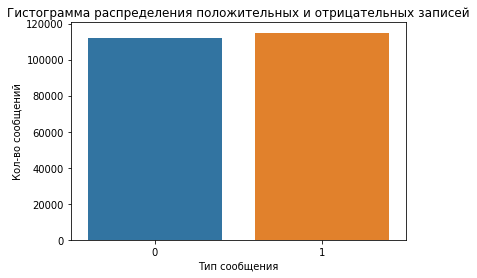

In [9]:
ax = sns.countplot(x=df['ttype'])
ax.set_title('Гистограмма распределения положительных и отрицательных записей')
ax.set_xlabel('Тип сообщения')
ax.set_ylabel('Кол-во сообщений')   

Классы сбалансированы.

Посмотрим на время написания сообщений, преобразуем timestamp в datetime формат

In [10]:
df.tdate = pd.to_datetime(df.tdate,unit='s')

###### 2.3.2 Даты написания первого и последнего сообщения в датасете:

In [11]:
print( "Первый твит:",df.tdate.min(), "\nПоследний твит",df.tdate.max())

Первый твит: 2013-12-06 10:32:07 
Последний твит 2014-01-20 05:31:54


Сообщения были собраны за полтора месяца.

###### 2.3.3 Длина сообщений

In [12]:
lens = df.ttext.str.len()
print("Средняя длина сообщения:",lens.mean(), "\nСреднеквадратичное отклонение:",lens.std(),"\nМаксимальная длина сообщения:", lens.max())

Средняя длина сообщения: 81.1298923441812 
Среднеквадратичное отклонение: 28.0130560325723 
Максимальная длина сообщения: 189


Text(0, 0.5, 'Кол-во сообщений')

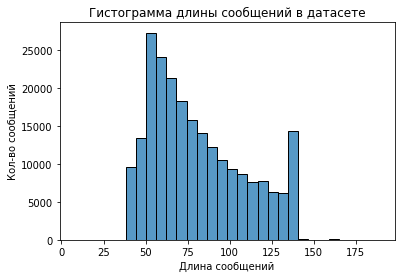

In [13]:
#lens.astype(int).hist()
ax = sns.histplot(x=lens.astype(int), bins=30)
ax.set_title('Гистограмма длины сообщений в датасете')
ax.set_xlabel('Длина сообщений')
ax.set_ylabel('Кол-во сообщений')   

Как видно по гистограмме, короткие сообщения были удалены из выборки.

###### 2.3.4 Длина для положительных и отрицательных сообщений

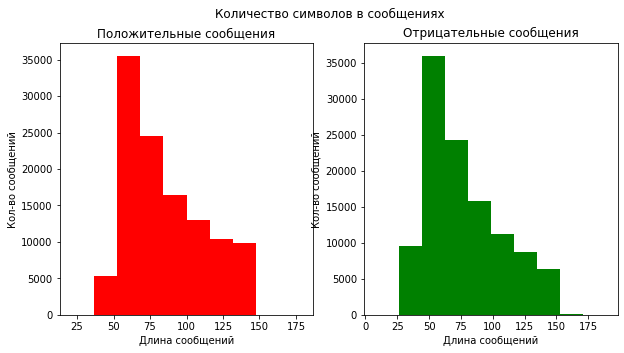

In [14]:
lens_1= df.loc[df['ttype'] == 1].ttext.str.len()
lens_0= df.loc[df['ttype'] == 0].ttext.str.len()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(lens_1,color='red')
ax1.set_title('Положительные сообщения')
ax1.set_xlabel('Длина сообщений')
ax1.set_ylabel('Кол-во сообщений')   
ax2.hist(lens_0,color='green')
ax2.set_title('Отрицательные сообщения')
ax2.set_xlabel('Длина сообщений')
ax2.set_ylabel('Кол-во сообщений')   
fig.suptitle('Количество символов в сообщениях')
plt.show()

###### 2.3.5 Количество слов в сообщениях

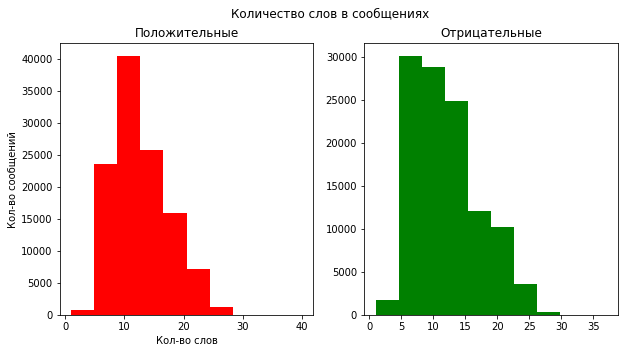

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df[df['ttype']==1]['ttext'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Положительные')
ax1.set_xlabel('Кол-во слов')
ax1.set_ylabel('Кол-во сообщений')   
tweet_len=df[df['ttype']==0]['ttext'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Отрицательные')
ax.set_xlabel('Кол-во слов')
ax.set_ylabel('Кол-во сообщений')   
fig.suptitle('Количество слов в сообщениях')
plt.show()

Посмотрим на сообщения, в которых количество слов меньше 5

In [16]:
df.loc[df['ttext'].str.split().map(lambda x: len(x)) < 5]['ttext']

11            RT @you_are_the_on: @uporoty_Horton плохо((9(
16        офигенный подарочек,офигенные цветочки:*спасиб...
125             @Potrochitel79 согласна...такой же вторник(
140       Буууу...01.12...чуть больше половины( http://t...
170       @mr_pavlov_maks тогда..что уж-берегите глаза,М...
                                ...                        
226222    Зашибись биология:) @KatyaSK http://t.co/RdGqX...
226236        Не выспалаась...Хожу как зоомбии!!!:(:(:(:(:(
226396        Проблемы гитаристов ;( http://t.co/8JxLnCFO3N
226805           Ребята, вы где?:( #MerryChristmasR5FromCIS
226823    ЛЕНТАААААА Я УМИРАААААААААЮ :(((((((((((((((((...
Name: ttext, Length: 2600, dtype: object

###### 2.3.6 Средняя длина слов в положительных и отрицательных сообщениях

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Средняя длина слов в сообщениях')

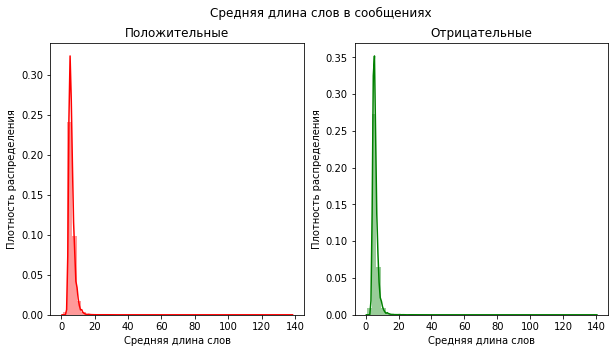

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['ttype']==1]['ttext'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Положительные')
ax1.set_xlabel('Средняя длина слов')  
ax1.set_ylabel('Плотность распределения')  
word=df[df['ttype']==0]['ttext'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Отрицательные')
ax2.set_xlabel('Средняя длина слов')  
ax2.set_ylabel('Плотность распределения')  
fig.suptitle('Средняя длина слов в сообщениях')

Посмторим на сообщения со словами, чья длина превышает 100 символов (и поправим атрибут pandas для ширины колонки, чтобы сообщения отображались полностью)

In [18]:
pd.options.display.max_colwidth = 100

In [19]:
df.loc[df['ttext'].str.split().apply(lambda x : [len(i) for i in x]).apply(lambda x: max(x)) > 100]['ttext']

11718     @KremlinRussia МногоЗнаете™:звякните:кто:может:СоплюНавесьтеЧуткО™:пидару-путину:как:он:15:лет:в...
36838     ВчераПолностьюОтчиталВесьНемецкийИпреподСказалЧтоОценкаПоЗачетуТолько3,ноМне3неНужно,яХочу4,вотП...
43828     RT @Molko_od: ХОЧУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУУ...
57100     @sofislava ((((((((((((((((((((((((((((((((((((((((((абидна((((((((((((((((((((((((((((((((99999...
58755     так приятно когда человек игнорит)))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))...
68656     RT @plo_otnik: леньленьленьленьленьленьленьленьленьленьеленьленьленьленьленьленьленьленьленьлень...
70009     Мама назвала меня тварью:(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((...
75236     @KremlinRussia Мы:же:не:хотим:чтобы:в:аэрокосмических&amp;технологических:вузах:были:кафедры:ваф...
80715     ГОРЕ!!!!!!!!!!!!!!!!!!у меня горе!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!((((((((((((((((((((((((((((((...
81240     

Как видим, по большей части это множественное написание скобок или использование разделителей, отличных от пробелов

###### 2.3.7 Стоп-слова

Создадим корпус слов из нашего датасета.

In [20]:
def create_corpus():
    corpus=[]
    
    for x in df['ttext'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [21]:
nltk.download('stopwords')
stop=set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Посмотрим на наиболее часто встречающиеся стоп-слова в сообщениях

In [22]:
corpus=create_corpus()
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Кол-во использований')

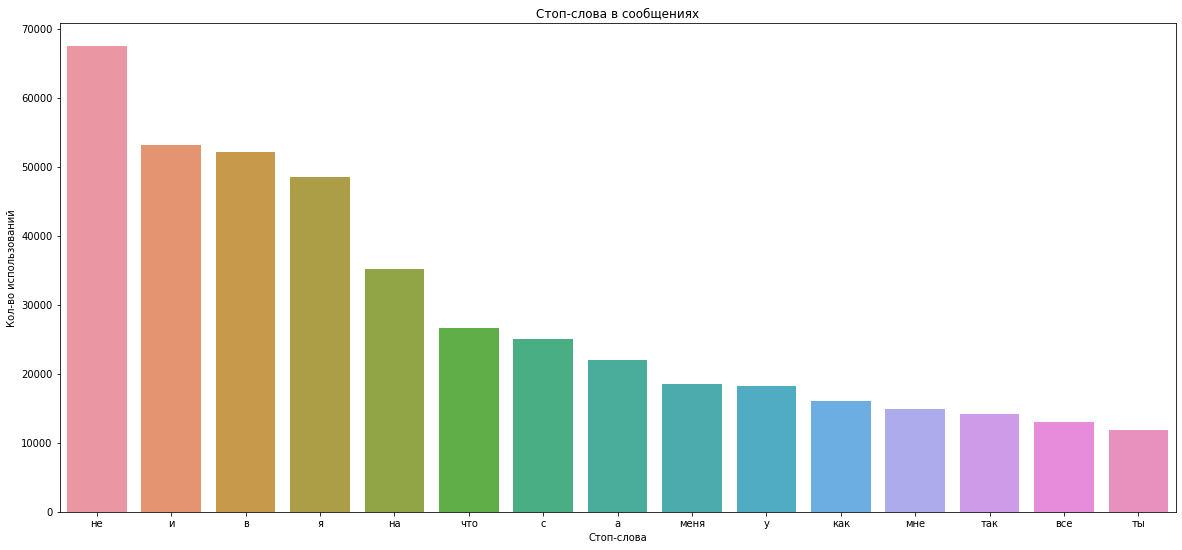

In [23]:
x,y=zip(*top)
plt.figure(figsize=(20,9))
ax = sns.barplot(np.array(x),np.array(y))
ax.set_title('Стоп-слова в сообщениях')
ax.set_xlabel('Стоп-слова')
ax.set_ylabel('Кол-во использований')   

###### 2.3.8 Пунктуация 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Кол-во использований')

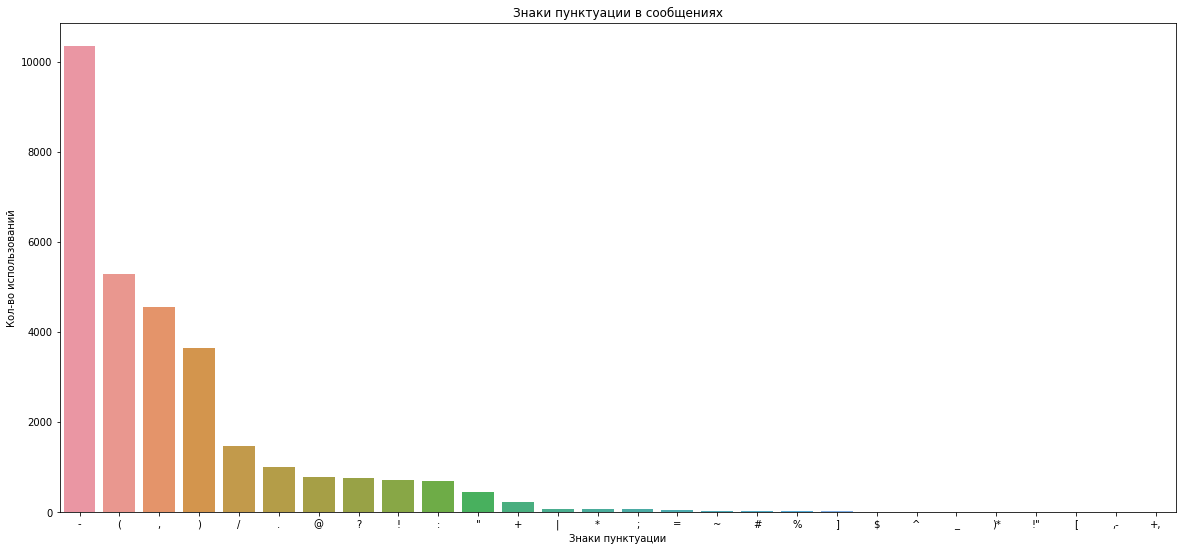

In [24]:
plt.figure(figsize=(20,9))
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
sorted_p = sorted(dic.items(), key=lambda x:x[1],reverse=True)
x,y=zip(*sorted_p)
ax = sns.barplot(np.array(x),np.array(y))
ax.set_title('Знаки пунктуации в сообщениях')
ax.set_xlabel('Знаки пунктуации')
ax.set_ylabel('Кол-во использований')   

###### 2.3.9 Популярные слова

Посмотрим на самые часто используемые слова (которые не входят в список стоп-слов)

In [25]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Кол-во использований')

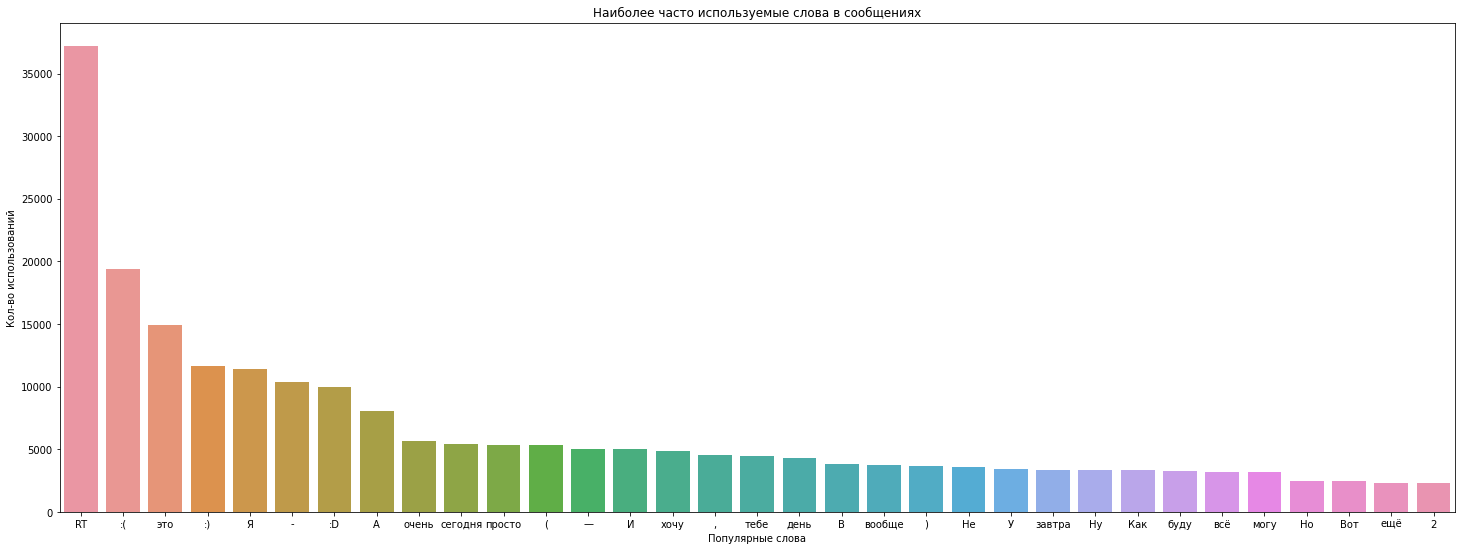

In [26]:
plt.figure(figsize=(25,9))
ax = sns.barplot(np.array(x),np.array(y))
ax.set_title('Наиболее часто используемые слова в сообщениях')
ax.set_xlabel('Популярные слова')
ax.set_ylabel('Кол-во использований')   

###### 2.3.10 Популярные N-граммы

Будем использовать функцию, которая посчитает частоту использования N-грамм в данных и вернет топ g используемых N грамм

In [27]:
def get_top_tweet_Ngrams(corpus, n=None, g=None):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Text(0, 0.5, 'Биграммы')

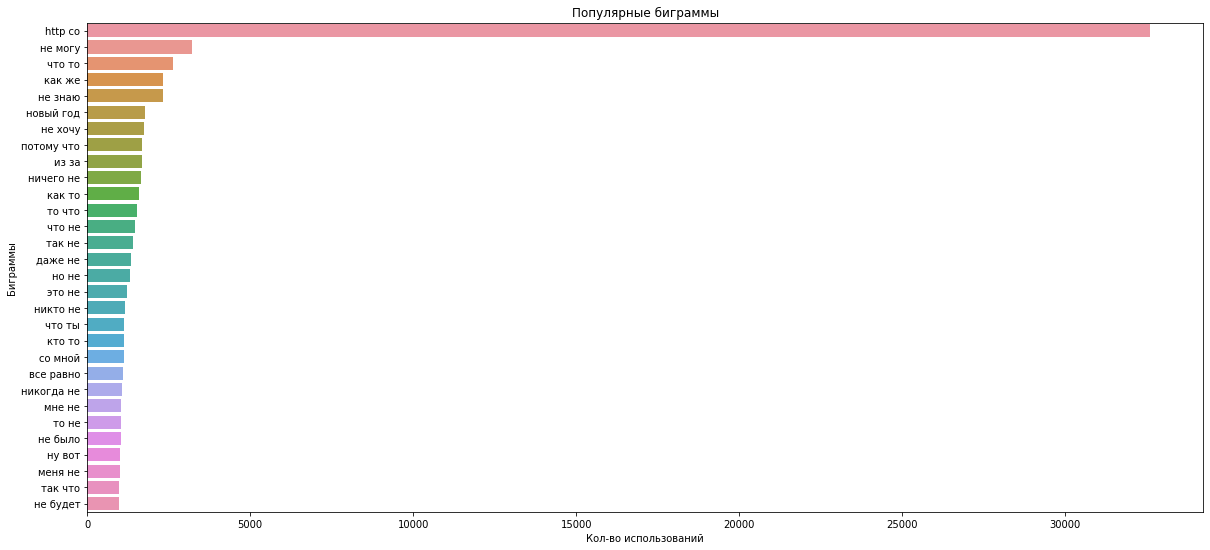

In [28]:
plt.figure(figsize=(20,9))
top_tweet_bigrams=get_top_tweet_Ngrams(df['ttext'],30,2)
x,y=map(list,zip(*top_tweet_bigrams))
ax =sns.barplot(x=y,y=x)
ax.set_title('Популярные биграммы')
ax.set_xlabel('Кол-во использований')
ax.set_ylabel('Биграммы')   

Text(0, 0.5, 'Триграммы')

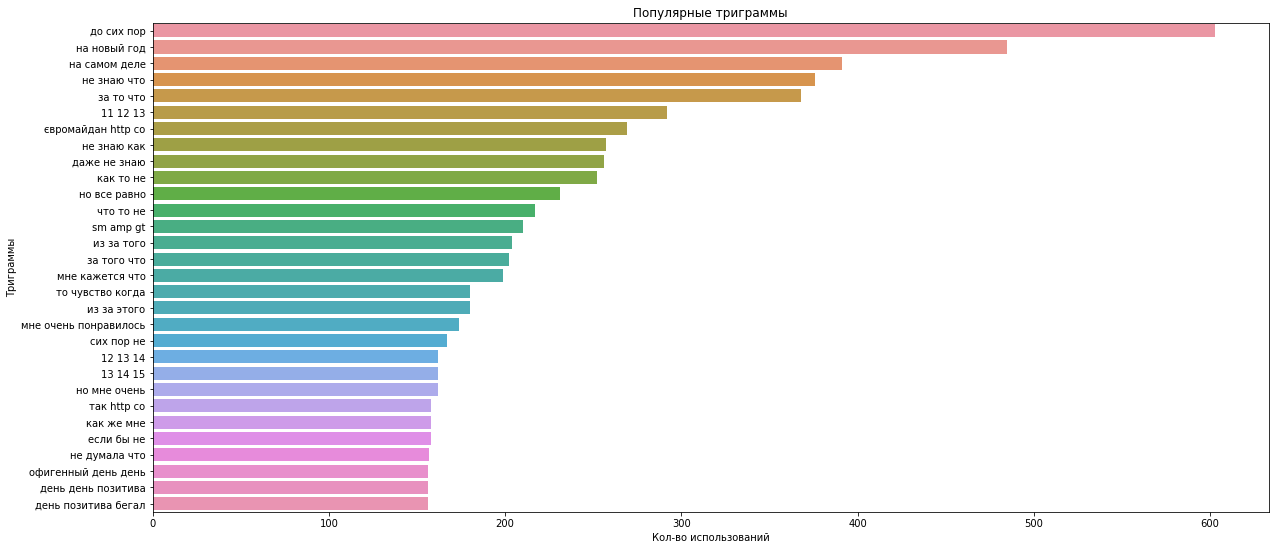

In [29]:
plt.figure(figsize=(20,9))
top_tweet_bigrams=get_top_tweet_Ngrams(df['ttext'],30,3)
x,y=map(list,zip(*top_tweet_bigrams))
ax =sns.barplot(x=y,y=x)
ax.set_title('Популярные триграммы')
ax.set_xlabel('Кол-во использований')
ax.set_ylabel('Триграммы')   

В данных часто упоминается Новый Год, так как сообщения были написаны в  промежутке с декабря по середину января.

##### 2.4 Очистка данных

Скопируем наш датасет, для последующей проверки моделей как на очищенных данных, так и на исходных

In [92]:
df_clean = df.copy()

###### 2.4.1 URL

Посчитаем сколько твитов содержит гиперссылки

In [93]:
print(df[df['ttext'].str.contains("http")].count()[0], "сообщений содержат гиперссылки. Это ", round(100*df[df['ttext'].str.contains("http")].count()[0]/df.count()[0],2), "% от общего числа сообщений")

32890 сообщений содержат гиперссылки. Это  14.5 % от общего числа сообщений


Напишем функцию для замены ссылок на токен

In [94]:
 example="Новый датасет опубликован :https://www.kaggle.com/"

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)
print(example)
print(remove_URL(example))

Новый датасет опубликован :https://www.kaggle.com/
Новый датасет опубликован :URL


In [95]:
df_clean['ttext']=df_clean['ttext'].apply(lambda x : remove_URL(x))

###### 2.4.2 HTML-теги

Будем использовать функцию для удаления HTML тегов

In [96]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

example = """<div>
<h1>Заголовок</h1>
<p>новости </p>
<a href="https://www.kaggle.com/">Kaggle</a>
</div>"""
print(remove_html(example))


Заголовок
новости 
Kaggle



In [97]:
df_clean['ttext']=df_clean['ttext'].apply(lambda x : remove_html(x))

###### 2.4.3 Замена обращений на токен

Большая часть сообщений содержит в с себе обращения к другим пользователям- это знак @, за которым следует username. Эти данные будут мешать нашим классификаторам, поэтому удалим их.

In [98]:
print(df_clean.loc[df_clean['ttext'].str.contains('@')].count()[0], "сообщений содержат гиперссылки. Это ", round(100*df_clean.loc[df_clean['ttext'].str.contains('@')].count()[0]/df.count()[0],2), "% от общего числа сообщений")

113754 сообщений содержат гиперссылки. Это  50.15 % от общего числа сообщений


In [99]:
def remove_mentions(text):
    return re.sub(r"@\S+", "REP", text)

example ='@username чо как?'
remove_mentions(example)

'REP чо как?'

In [100]:
df_clean['ttext']=df_clean['ttext'].apply(lambda x : remove_mentions(x))

###### 2.4.4 Замена смайлов на токены

In [101]:
!pip install emoji

In [102]:
import emoji
text = "game is on 🔥 🔥"
emoji.demojize(text, delimiters=("", ""))  # 'game is on fire fire'

'game is on fire fire'

In [103]:
def replace_emoji(text):
  return emoji.demojize(text, delimiters=("", ""))

In [104]:
df_clean['ttext']=df_clean['ttext'].apply(lambda x : replace_emoji(x))

###### 2.4.5 Замена скобок на токены

In [111]:
def replace_c_brakets(text):
  if ")" in text and "(" in text:
    return text
  else:
  
    return re.sub('\)+', ' GOOD', text)

In [106]:
example = "все очень хорошо )))"
replace_c_brakets(example)

'все очень хорошо  GOOD'

In [107]:
def replace_o_brakets(text):
  if ")" in text and "(" in text:
    return text
  else:
    return re.sub('\(+', ' BAD', text)

In [108]:
example = "все очень плохо ((("
replace_o_brakets(example)

'все очень плохо  BAD'

In [109]:
df_clean['ttext']=df_clean['ttext'].apply(lambda x : replace_c_brakets(x))
df_clean['ttext']=df_clean['ttext'].apply(lambda x : replace_o_brakets(x))

In [110]:
df_clean.head()

,id,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,410837971173408768,2013-12-11 18:26:19,Divanka394,"REP ну, у меня ассоциации, например когда мама говорит сыну ""солнце МОЁ"", и он действительно ее ...",1,0,0,0,6074,117,48,2
1,410402420259561473,2013-12-10 13:35:36,KolomietsRuslan,"Позвонила в 4 утра,разбудила и начала петь песню ; GOOD",1,0,0,0,13318,1670,46,0
2,409497410604646400,2013-12-08 01:39:25,zelenskij,"Теперь вспоминай все слова На ""ум"" в этом городе- Цум, Гум, Атриум, Подиум GOOD",1,0,0,0,578,6,2,0
3,419184008795529216,2014-01-03 19:10:30,Grazy_Russian,REP азазаза спиздил идею азаза ты мне больши ни бро азаз BAD999 BAD9999999 BAD,0,0,0,0,516,690,1143,0
4,419516067623337984,2014-01-04 17:09:59,bondarenkoooooo,REP ты как вообще там? уехал же BAD,0,0,0,0,753,21,17,0


###### 2.4.6 Удаление пунктуации

Удалим пунктуацию и заменим ее на пробелы, так как часть сообщений написано с использованием случайных символов для разделения строк

In [112]:
def remove_punct(text):
    table=str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return text.translate(table)
example="Пример;для*обработки"
print(remove_punct(example))

Пример для обработки


In [113]:
df_clean['ttext']=df_clean['ttext'].apply(lambda x : remove_punct(x))

###### 2.4.7 Удаление стоп-слов

In [114]:
def removeStopWords(sentence):
    token_words=word_tokenize(sentence)
    filtered_words = [word for word in token_words if word not in stop]
    return " ".join(filtered_words)

In [115]:
print("Оригинальное сообщение:")
print(df_clean['ttext'][15])
print("Сообщение без стоп-слов:")
print(removeStopWords(df_clean['ttext'][15]))

Оригинальное сообщение:
REP Эх         очень сложно   BAD
Сообщение без стоп-слов:
REP Эх очень сложно BAD


In [116]:
df_clean['ttext']=df_clean['ttext'].apply(lambda x : removeStopWords(x))

###### 2.4.8 Удаление "RT" из текстов

In [117]:
print(df_clean[df_clean['ttext'].str.contains("RT")].count()[0], "твитов содержат RT")

37005 твитов содержат RT


In [118]:
def removeRT(text):
  return re.sub(r'\bRT\b\s+',"",text)

In [119]:
print("Оригинальное сообщение:")
print(df_clean['ttext'][15])
print("Сообщение без RT:")
print(removeRT(df_clean['ttext'][15]))

Оригинальное сообщение:
REP Эх очень сложно BAD
Сообщение без RT:
REP Эх очень сложно BAD


In [ ]:
#df_clean['ttext']=df_clean['ttext'].apply(lambda x : removeRT(x))

###### 2.4.9 Лемматизация

Применим lemmer, который поддерживает русский язык

In [ ]:
'''from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("russian") 
stemmer.stem("всем выпускникам удачи завтра русском сможем")'''

'from nltk.stem.snowball import SnowballStemmer \nstemmer = SnowballStemmer("russian") \nstemmer.stem("всем выпускникам удачи завтра русском сможем")'

In [120]:
nlp = Russian()

def lemmatization(text):
   doc = nlp(text)
   tokens = [token.lemma_ for token in doc]
   return " ".join(tokens)

In [121]:
print("Оригинальное сообщение:")
print(df_clean['ttext'][15])
print("Сообщение с леммами:")
print(lemmatization(df_clean['ttext'][15]))


Оригинальное сообщение:
REP Эх очень сложно BAD
Сообщение с леммами:
rep Эх очень сложно bad


In [122]:
df_clean['ttext']=df_clean['ttext'].progress_apply(lambda x : lemmatization(x))

100%|██████████| 226834/226834 [05:05<00:00, 743.46it/s]


##### 2.5 Сохранение данных

In [124]:
from google.colab import files

df.to_csv('df2.csv')
df_clean.to_csv('df_clean_2.csv')
files.download('df2.csv')
files.download('df_clean_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### 2.6 Проверка результата на твитах

В ходе просмотра датасета, мы находили сообщения, в которых было всего пару слов, посмотрим что с ними стало после очистки данных

In [125]:
print("Без обработки:")
print(df['ttext'][22109])
print("\nПосле обработки:")
print(df_clean['ttext'][22109])

Без обработки:
@heycuddy нет ((((((((
Чо такая тупая тогда

После обработки:
rep bad чо такая тупой


In [126]:
print("Без обработки:")
print(df['ttext'][10322 ])
print("\nПосле обработки:")
print(df_clean['ttext'][10322])

Без обработки:
RT @_Borny_: Мы получили самую главную премию - это наши поклонники!! Спасибо вам)) #4post #4post4ever #mofk http://t.co/4XRHnYovQo

После обработки:
rt rep мы получить самый главный премия это наши поклонник Спасибо good 4post 4post4ever mofk url


#### 3. Модели

##### 3.1 Импорт библиотек

In [127]:
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

##### 3.2 Train Test Split

Разделим оба датасета- с очищенными данными и оригинальными

In [128]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
#df_train, df_val = train_test_split(df_test, test_size=0.2, shuffle=True, random_state=42)

In [129]:
df_train.shape, df_test.shape#, df_val.shape

((181467, 12), (45367, 12))

In [130]:
df_c_train, df_c_test = train_test_split(df_clean, test_size=0.2, shuffle=True, random_state=42)
#df_c_train, df_c_val = train_test_split(df_c_test, test_size=0.2, shuffle=True, random_state=42)

In [131]:
df_c_train.shape, df_c_test.shape#, df_c_val.shape

((181467, 12), (45367, 12))

##### 3.3 Baseline models

###### 3.3.1 MultinomialNB

**Count vectorization**

In [132]:
count_vect = CountVectorizer(binary=False).fit(df['ttext'])

X_train_counts = count_vect.transform(df_train['ttext'])
X_test_counts = count_vect.transform(df_test['ttext'])

count_vect = CountVectorizer(binary=False).fit(df_clean['ttext'])

X_c_train_counts = count_vect.transform(df_c_train['ttext'])
X_c_test_counts = count_vect.transform(df_c_test['ttext'])

**Алгоритм**

Обучим MultinomialNB на оригинальных данных

In [133]:
clf = MultinomialNB().fit(X_train_counts, df_train['ttype'])

In [134]:
# train
predicts = clf.predict(X_train_counts)
print(classification_report(df_train['ttype'], predicts))

              precision    recall  f1-score   support

           0       0.87      0.93      0.89     89765
           1       0.92      0.86      0.89     91702

    accuracy                           0.89    181467
   macro avg       0.89      0.89      0.89    181467
weighted avg       0.89      0.89      0.89    181467



In [135]:
# test
predicts = clf.predict(X_test_counts)
print(classification_report(df_test['ttype'], predicts))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76     22158
           1       0.79      0.71      0.75     23209

    accuracy                           0.76     45367
   macro avg       0.76      0.76      0.76     45367
weighted avg       0.76      0.76      0.76     45367



Обучим на очищенных данных

In [136]:
clf_с = MultinomialNB().fit(X_c_train_counts, df_train['ttype'])

In [137]:
# train
predicts = clf_с.predict(X_c_train_counts)
print(classification_report(df_c_train['ttype'], predicts))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     89765
           1       0.98      0.97      0.97     91702

    accuracy                           0.97    181467
   macro avg       0.97      0.97      0.97    181467
weighted avg       0.97      0.97      0.97    181467



In [138]:
# test
predicts = clf_с.predict(X_c_test_counts)
print(classification_report(df_c_test['ttype'], predicts))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     22158
           1       0.97      0.96      0.96     23209

    accuracy                           0.96     45367
   macro avg       0.96      0.96      0.96     45367
weighted avg       0.96      0.96      0.96     45367



Функция для подсчета N лучших (по вероятностям) слов для каждого класса

In [144]:
def show_top(classifier, vectorizer, n, categories=('Negative', 'Positive')):
    # получаем слова
    feature_names = np.asarray(vectorizer.get_feature_names())
    # проходимлся по словам
    for i, category in enumerate(categories):
        # выбираем лучшие по вероятностям
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print("%s: %s" % (category, " ".join(feature_names[top])))

In [145]:
vectorizer = CountVectorizer(binary=True)
vectorizer_с = CountVectorizer(binary=True)
vectorizer.fit(df['ttext'])
vectorizer_с.fit(df_clean['ttext'])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Посмотрим, как изменилось количество различных слов после обработки данных

In [146]:
print("Кол-во слов в словаре оригинального датасета:",len(vectorizer.vocabulary_))
print("Кол-во слов в словаре очищенного датасета:",len(vectorizer_с.vocabulary_))

Кол-во слов в словаре оригинального датасета: 294600
Кол-во слов в словаре очищенного датасета: 143557


После очистки и лемматизации словарь уменьшился вдвое

N лучших (по вероятностям) слов для каждого класса

In [147]:
show_top(clf, vectorizer, 20)

Negative: хочу за уже ты по ну это все но так http co мне то как меня rt на что не
Positive: вот да за по ну но мне все так меня ты то это как что на rt co http не


In [148]:
show_top(clf_с, vectorizer_с, 20)

Negative: как делать вообще почему знать быть просто не блин завтра очень мочь сегодня день хотеть это url rt rep bad
Positive: завтра мочь смотреть сказать всё знать любить очень спасибо хотеть быть просто тебе сегодня день это rt url rep good


###### 3.3.2 TF-IDF

In [149]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(df['ttext'])
vectorizer_c = TfidfVectorizer()
vectorizer_c = vectorizer.fit(df_clean['ttext'])

In [150]:
X_train_vectors = vectorizer.transform(df_train['ttext'])
X_test_vectors = vectorizer.transform(df_test['ttext'])

X_c_train_vectors = vectorizer.transform(df_c_train['ttext'])
X_c_test_vectors = vectorizer.transform(df_c_test['ttext'])

**Алгоритм**

In [151]:
clf = MultinomialNB().fit(X_train_vectors, df_train['ttype'])
clf_c = MultinomialNB().fit(X_c_train_vectors, df_c_train['ttype'])

Результат предсказаний для оригинального датасета:

In [152]:
predicts = clf.predict(vectorizer.transform(df_test['ttext']))
print(classification_report(df_test['ttype'], predicts))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71     22158
           1       0.73      0.69      0.71     23209

    accuracy                           0.71     45367
   macro avg       0.71      0.71      0.71     45367
weighted avg       0.71      0.71      0.71     45367



Результат предсказаний для очищенного датасета:

In [153]:
predicts = clf_с.predict(vectorizer.transform(df_c_test['ttext']))
print(classification_report(df_c_test['ttype'], predicts))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     22158
           1       0.93      0.92      0.92     23209

    accuracy                           0.92     45367
   macro avg       0.92      0.92      0.92     45367
weighted avg       0.92      0.92      0.92     45367



###### 3.3.3 TF-IDF + N-grams

In [154]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2)).fit(df['ttext'])
vectorizer_c = TfidfVectorizer(ngram_range=(1, 2)).fit(df_clean['ttext'])

X_train_vectors = vectorizer.transform(df_train['ttext'])
X_test_vectors = vectorizer.transform(df_test['ttext'])

X_c_train_vectors = vectorizer_c.transform(df_c_train['ttext'])
X_c_test_vectors = vectorizer_c.transform(df_c_test['ttext'])

Алгоритм

In [155]:
clf = MultinomialNB(alpha = 0.5).fit(X_train_vectors, df_train['ttype'])
clf_c = MultinomialNB(alpha = 0.5).fit(X_c_train_vectors, df_c_train['ttype'])

Результат предсказаний для оригинального датасета:

In [156]:
predicts = clf.predict(X_test_vectors)
print(classification_report(df_test['ttype'], predicts))

              precision    recall  f1-score   support

           0       0.73      0.82      0.77     22158
           1       0.81      0.71      0.75     23209

    accuracy                           0.76     45367
   macro avg       0.77      0.77      0.76     45367
weighted avg       0.77      0.76      0.76     45367



Результат предсказаний для очищенного датасета:

In [157]:
predicts = clf_c.predict(X_c_test_vectors)
print(classification_report(df_c_test['ttype'], predicts))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     22158
           1       0.95      0.93      0.94     23209

    accuracy                           0.94     45367
   macro avg       0.94      0.94      0.94     45367
weighted avg       0.94      0.94      0.94     45367



###### 3.3.4 Dummy classifier 

Попробуем классифицировать сообщения по наличию '(' и ')' в сообщениях.
Если предложение содержит обе скобки, то посчитаем, каких скобок больше.
Если содержит закрывающую скобку - классифицируем как положительное. Во всех других случаях считаем что сообщение негативное.

In [158]:
def make_predictions(data):
  result=[]
  for sentence in data:
    if ("(" in sentence) and  ( ")" in sentence):
      if sentence.count(')') > sentence.count('('):
        result.append(1)
      else:
         result.append(0)
    elif ")" in sentence:
      result.append(1)
    else:
      result.append(0)
  return result

In [159]:
predictions = make_predictions(df['ttext'])

In [160]:
print(classification_report(df['ttype'], predictions))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92    111923
           1       1.00      0.83      0.91    114911

    accuracy                           0.91    226834
   macro avg       0.93      0.91      0.91    226834
weighted avg       0.93      0.91      0.91    226834



В датасете отсутствуют негативно оцененные твиты, содержащие скобку ")"

In [ ]:
res = 0
res_p = 0
res_n = 0 
for i in range(df.shape[0]):
  if ")" in df.iloc[i]['ttext']:
    res+=1
    if df.iloc[i]['ttype']==1:
      res_p+=1
    else:
      res_n+=1


In [ ]:
print("Количество твитов со скобкой ')': ", res,
        "\nКоличество положительных твитов со скобкой ')': ", res_p,
        "\nКоличество отрицательных твитов со скобкой ')': ", res_n)

Количество твитов со скобкой ')':  95257 
Количество положительных твитов со скобкой ')':  95257 
Количество отрицательных твитов со скобкой ')':  0


##### 3.4 Words Embeddings 

###### 3.4.1 Импорт библиотек

In [161]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np 
print(tf.__version__)

2.4.1


###### 3.4.2 Train Test Split

In [162]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=42)

df_c_train, df_с_test = train_test_split(df_clean, test_size=0.2, shuffle=True, random_state=42)
df_c_train, df_c_val = train_test_split(df_c_train, test_size=0.2, shuffle=True, random_state=42)

In [163]:
df_train.shape, df_test.shape, df_val.shape

((145173, 12), (45367, 12), (36294, 12))

In [164]:
df_c_train.shape, df_c_test.shape, df_c_val.shape

((145173, 12), (45367, 12), (36294, 12))

###### 3.4.4 Подготовка данных для модели

In [165]:
dataset_train = tf.data.Dataset.from_tensor_slices((df_c_train['ttext'].values, df_c_train['ttype'].values))
dataset_test = tf.data.Dataset.from_tensor_slices((df_c_test['ttext'].values, df_c_test['ttype'].values))
dataset_val = tf.data.Dataset.from_tensor_slices((df_c_val['ttext'].values, df_c_val['ttype'].values))

#dataset_c_train = tf.data.Dataset.from_tensor_slices((df_c_train['ttext'].values, df_c_train['ttype'].values))
#dataset_c_test = tf.data.Dataset.from_tensor_slices((df_c_test['ttext'].values, df_c_test['ttype'].values))
#dataset_c_val = tf.data.Dataset.from_tensor_slices((df_c_val['ttext'].values, df_c_val['ttype'].values))

In [166]:
train_data, test_data, val_data = dataset_train,dataset_test, dataset_val
training_sentences = []
training_labels = []
val_sentences = []
val_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

for s,l in val_data:
  val_sentences.append(s.numpy().decode('utf8'))
  val_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
val_labels_final = np.array(val_labels)

In [167]:
vocab_size = 30000 #10000
embedding_dim = 16
max_length = 180
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)
val_sequences =  tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences,maxlen=max_length)

In [168]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? как <OOV> час я 3 час назад школы пришла bad
Как 12ый час Я 3 час назад школы пришла bad


###### 3.4.5 Модель

In [169]:
import keras
from keras.optimizers import Adam

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000, #10000
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 16)           480000    
_________________________________________________________________
flatten (Flatten)            (None, 2880)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 17286     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 497,293
Trainable params: 497,293
Non-trainable params: 0
_________________________________________________________________


###### 3.4.6 Обучение модели

In [170]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(val_padded, val_labels_final))

Epoch 1/10
4537/4537 [==============================] - 30s 6ms/step - loss: 0.3990 - accuracy: 0.8530 - val_loss: 0.0454 - val_accuracy: 0.9820
Epoch 2/10
4537/4537 [==============================] - 28s 6ms/step - loss: 0.0353 - accuracy: 0.9875 - val_loss: 0.0344 - val_accuracy: 0.9840
Epoch 3/10
4537/4537 [==============================] - 28s 6ms/step - loss: 0.0246 - accuracy: 0.9911 - val_loss: 0.0321 - val_accuracy: 0.9846
Epoch 4/10
4537/4537 [==============================] - 28s 6ms/step - loss: 0.0205 - accuracy: 0.9926 - val_loss: 0.0312 - val_accuracy: 0.9852
Epoch 5/10
4537/4537 [==============================] - 28s 6ms/step - loss: 0.0170 - accuracy: 0.9941 - val_loss: 0.0307 - val_accuracy: 0.9854
Epoch 6/10
4537/4537 [==============================] - 29s 6ms/step - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0.0308 - val_accuracy: 0.9855
Epoch 7/10
4537/4537 [==============================] - 28s 6ms/step - loss: 0.0137 - accuracy: 0.9956 - val_loss: 0.0316 - val_ac

In [171]:
predictions = model.predict(testing_padded)

In [172]:
print(classification_report(predictions.round().astype(int),testing_labels_final))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     22189
           1       0.99      0.99      0.99     23178

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367



Посмотрим как менялись метрики в ходе обучения и как изменялись значения функции ошибки

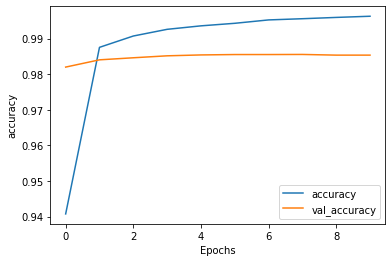

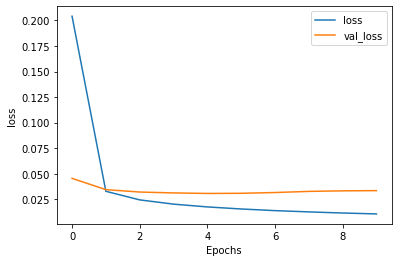

In [173]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Выгрузим значения весов Embedding слоя нашей сети

In [174]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(30000, 16)


Сохраним значения embeddings и метаданные в файл.

In [175]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [176]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Файлы с векторами и метаданными можно загрузить на https://projector.tensorflow.org/ и посмотреть PCA и другие типы кластеризаций и отображения:
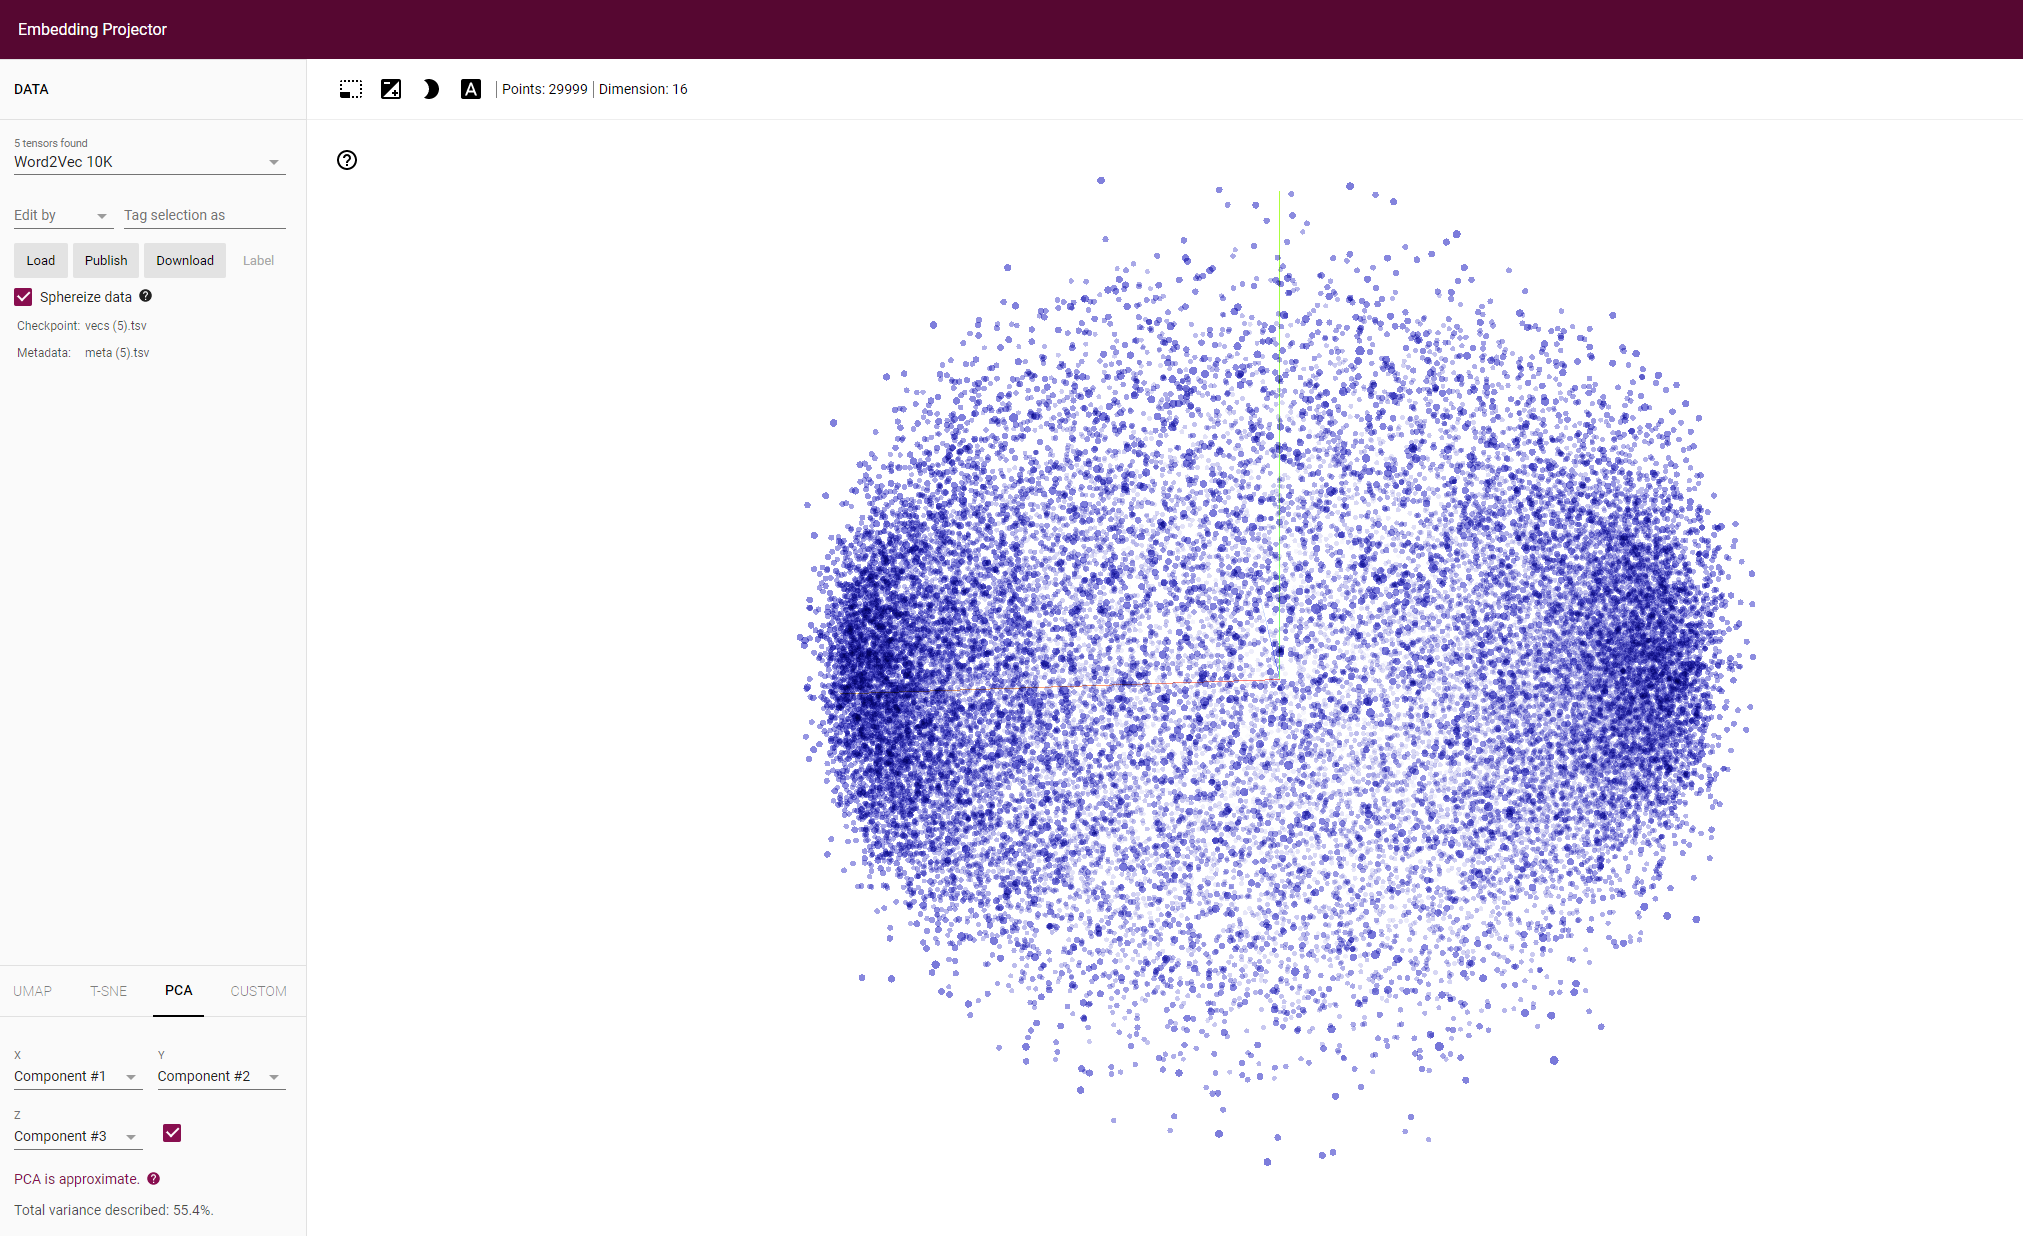

##### 3.5 LTSM

###### 3.5.1 Подготовка модели LTSM

In [177]:
modelLTSM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [179]:
modelLTSM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1920000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,031,489
Trainable params: 2,031,489
Non-trainable params: 0
_________________________________________________________________


In [180]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000, #10000
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [181]:
modelLTSM.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

###### 3.5.2 Обучение модели

In [182]:
NUM_EPOCHS = 10
history = modelLTSM.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(val_padded, val_labels_final))

Epoch 1/10
4537/4537 [==============================] - 226s 48ms/step - loss: 0.1518 - accuracy: 0.9462 - val_loss: 0.0361 - val_accuracy: 0.9831
Epoch 2/10
4537/4537 [==============================] - 216s 48ms/step - loss: 0.0239 - accuracy: 0.9898 - val_loss: 0.0434 - val_accuracy: 0.9807
Epoch 3/10
4537/4537 [==============================] - 216s 48ms/step - loss: 0.0160 - accuracy: 0.9937 - val_loss: 0.0382 - val_accuracy: 0.9840
Epoch 4/10
4537/4537 [==============================] - 217s 48ms/step - loss: 0.0111 - accuracy: 0.9958 - val_loss: 0.0422 - val_accuracy: 0.9837
Epoch 5/10
4537/4537 [==============================] - 218s 48ms/step - loss: 0.0095 - accuracy: 0.9965 - val_loss: 0.0391 - val_accuracy: 0.9841
Epoch 6/10
4537/4537 [==============================] - 218s 48ms/step - loss: 0.0080 - accuracy: 0.9970 - val_loss: 0.0472 - val_accuracy: 0.9842
Epoch 7/10
4537/4537 [==============================] - 217s 48ms/step - loss: 0.0072 - accuracy: 0.9974 - val_loss: 0

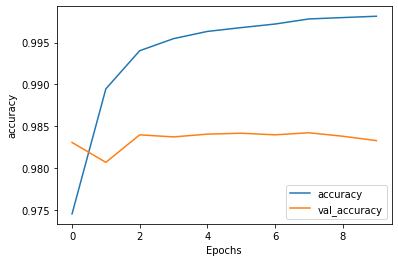

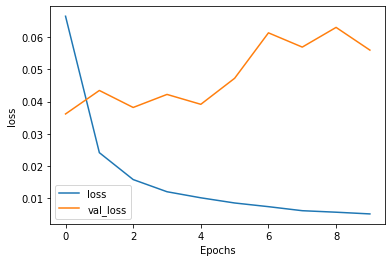

In [183]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [184]:
predictionsLTSM = modelLTSM.predict(testing_padded)

In [185]:
print(classification_report(predictionsLTSM.round().astype(int),testing_labels_final))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     22101
           1       0.99      0.98      0.98     23266

    accuracy                           0.98     45367
   macro avg       0.98      0.98      0.98     45367
weighted avg       0.98      0.98      0.98     45367



##### 3.5 BERT

В данном разделе попробуем дообучить на наших данных предобученную модель BERT от DeepPavlov - RuBert (https://deeppavlov.ai/)

###### 3.5.1 Подготовка TF модели

Установим библиотеку transformers

In [186]:
!pip install transformers

     |████████████████████████████████| 1.8MB 5.8MB/s 
     |████████████████████████████████| 3.2MB 49.5MB/s 
     |████████████████████████████████| 890kB 51.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=1d54330de4e899724bfd3ea863496f0390bd966850c549285d61ef2eaf4dde7f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


К сожалению нельзя сразу загрузить предобученную TensorFlow модель от DeepPavlov, поэтому сначала загрузим PyTorch модель, сохраним ее, после чего загрузим TF модель из сохраненных данных.

In [187]:
from transformers import BertForSequenceClassification
bert_pytorch = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased-sentence" )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Сохраним модель в Google Drive

In [ ]:
bert_pytorch.save_pretrained('/content/drive/MyDrive/rubert-base-cased-sentence/')

Теперь загрузим TF модель BertForSequenceClassification из сохраненной PyTorch модели

In [190]:
from transformers import TFBertForSequenceClassification
modelTF = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/rubert-base-cased-sentence/", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


###### 3.5.2 Train Test Split

In [191]:
texts = df['ttext'].values.tolist()
labels = df['ttype'].values.tolist()

In [192]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels, shuffle=True)
print("train_texts: ", len(train_texts))
print("test_texts: ", len(test_texts))
print("train_labels: ", len(train_labels))
print("test_labels: ",len(test_labels))

train_texts:  181467
test_texts:  45367
train_labels:  181467
test_labels:  45367


In [193]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels ,shuffle=True)
print("train_texts: ", len(train_texts))
print("val_texts: ", len(val_texts))
print("train_labels: ", len(train_labels))
print("val_labels: ", len(val_labels))

train_texts:  145173
val_texts:  36294
train_labels:  145173
val_labels:  36294


###### 3.5.3 Tokenization

Загрузим токенизатор из той же  модели

In [194]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [195]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Преобразуем наши данные в tf.dataset

In [196]:
#prepare data with TF
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings)#,
    #test_labels
))

In [197]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6) #3e-5
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
modelTF.compile(optimizer=optimizer, loss=loss, metrics=[metric])
modelTF.fit(train_dataset.batch(16), epochs=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f959c0fe2a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f959c0fe2a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf

Получим предсказания для тестового дата-сета

In [198]:
predictions = modelTF.predict(test_dataset.batch(16))

In [199]:
predictions.logits.shape

(45367, 2)

Поскольку результат предсказаний мы получаем в виде logits, нам нужно применить softmax функцию для получения вероятностей, после чего мы  можем принадлежность к тому или иному классу

In [200]:
y_pred = tf.nn.softmax(predictions.logits)

In [201]:
y_pred_argmax = tf.math.argmax(y_pred, axis=1)

In [202]:
print(classification_report(y_pred_argmax,test_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22382
           1       1.00      1.00      1.00     22985

    accuracy                           1.00     45367
   macro avg       1.00      1.00      1.00     45367
weighted avg       1.00      1.00      1.00     45367



PyTroch RuBERT

In [25]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [26]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [27]:
import torch

class TWDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TWDataset(train_encodings, train_labels)
val_dataset = TWDataset(val_encodings, val_labels)
test_dataset = TWDataset(test_encodings, test_labels)

In [29]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

#bert_pytorch = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased-sentence" )

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    save_total_limit=2,
    
)

modelPT = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased-sentence" )

trainer = Trainer(
    model=modelPT,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.688400
20,0.676200
30,0.674200
40,0.662500
50,0.626000
60,0.591200
70,0.512600
80,0.339800
90,0.167600
100,0.101500


TrainOutput(global_step=9074, training_loss=0.011804238778448438, metrics={'train_runtime': 2604.7861, 'train_samples_per_second': 3.484, 'total_flos': 20604153095512812, 'epoch': 1.0})

In [30]:
trainer.evaluate(eval_dataset = test_dataset)

{'epoch': 1.0,
 'eval_loss': 0.0014491131296381354,
 'eval_runtime': 183.2476,
 'eval_samples_per_second': 247.572}

### Вывод

Задача классфикации сообщений в социальных сетях отличается от задач семантичесого анализа отзывов:
в первом случае мы имеем дело со спонтанными высказываниями, неким "mind flow", который зачастую носит неструктурированных характер и больше основан на передаче чувств и эмоций, в то время как отзывы - более продуманные тексты, со структурой и описанием положительных\отрицательных сторон.

Ниже таблица резульатов выполнения моделей на данных с обработкой и без нее.


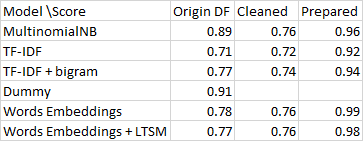

Не смотря на хорошие результаты у самых простых моделей, нейронные сети показали лучший результат.
Можно сделать пайплайн по обработке входных данных и получении результата классификации сети, но для работы с реальными данными стоит добавить или еще один класс - "нейтральный", или выстроить цепочку классификаторов.
Большое значение имеет обработка данных, так как в зависимости от модели, различные техники и подходы могут как улучшить результат, так и ухудшить его.
Удаление пунктуации, ссылок, обращений ухудшило результат, при этом их замена на токены дала существенный прирост в точности классификации.